Necessary imports

In [11]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import pyautogui
import mediapipe as mp

Loading the data

In [12]:
def load_data(data_dir, image_size=(64, 64)):
    images = []
    labels = []
    
    # Loop through each outer folder (00, 01, 02...)
    for outer_folder in os.listdir(data_dir):
        outer_folder_path = os.path.join(data_dir, outer_folder)
        
        if os.path.isdir(outer_folder_path):
            # Now loop through the inner folders (01_palm, 02_l, etc.)
            for inner_folder in os.listdir(outer_folder_path):
                inner_folder_path = os.path.join(outer_folder_path, inner_folder)
                
                if os.path.isdir(inner_folder_path):
                    # Loop through images in the inner folder
                    for img_name in os.listdir(inner_folder_path):
                        img_path = os.path.join(inner_folder_path, img_name)
                        
                        # Load the image
                        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                        
                        if image is not None:
                            # Resize the image to the target size
                            image = cv2.resize(image, image_size)
                            
                            # Normalize the pixel values
                            image = image / 255.0
                            
                            # Append the image and its label
                            images.append(image)
                            labels.append(inner_folder)  # Use the inner folder name as the label

    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    # Convert labels to numerical values
    unique_labels = {label: idx for idx, label in enumerate(np.unique(labels))}
    numerical_labels = np.array([unique_labels[label] for label in labels])

    return images, numerical_labels, unique_labels

In [13]:
data_dir = "./dataset"

# Load the data
images, labels, unique_labels = load_data(data_dir)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Reshape the data for the model
X_train = X_train.reshape(-1, 64, 64, 1)
X_test = X_test.reshape(-1, 64, 64, 1)

# Print shapes for verification
print(f"Training data shape: {X_train.shape}, Labels shape: {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, Labels shape: {y_test.shape}")

Training data shape: (16000, 64, 64, 1), Labels shape: (16000,)
Testing data shape: (4000, 64, 64, 1), Labels shape: (4000,)


Building the model

In [14]:
def build_model(num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')  # Adapt output layer to number of classes
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [15]:
model = build_model(len(unique_labels))

c:\Users\alist\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training and evaluating the model

In [16]:
def train_model(model, train_images, train_labels):
    history = model.fit(train_images, train_labels, epochs=10, validation_split=0.2)
    model.save('gesture_recognition_model.h5') 
    return history  # Return the training history for graph plotting

In [17]:
def evaluate_model(model, test_images, test_labels):
    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print(f'Test Accuracy: {test_acc}')

In [18]:
evaluate_model(model, X_test, y_test)

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.1069 - loss: 2.3006
Test Accuracy: 0.11124999821186066


Statistics plot

In [19]:
def plot_training_history(history):
    # Plot accuracy
    plt.figure(figsize=(12, 4))

    # Subplot 1: Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Subplot 2: Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [20]:
history = train_model(model, X_train, y_train)

Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.7550 - loss: 0.7274 - val_accuracy: 0.9981 - val_loss: 0.0076
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.9990 - loss: 0.0046 - val_accuracy: 0.9994 - val_loss: 0.0027
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.9935 - loss: 0.0232 - val_accuracy: 0.9991 - val_loss: 0.0032
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.9997 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 4.5470e-04
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - accuracy: 1.0000 - loss: 3.9348e-04 - val_accuracy: 0.9994 - val_loss: 0.0014
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 1.0000 - loss: 1.8976e-05 - val_accuracy: 0.9994 - val_loss: 0.0014
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - accuracy: 1.0000 - loss: 1.1644e-05 - val_accuracy: 0.9994 - val_loss: 0.0011
Epoch 8/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 1.0000 -

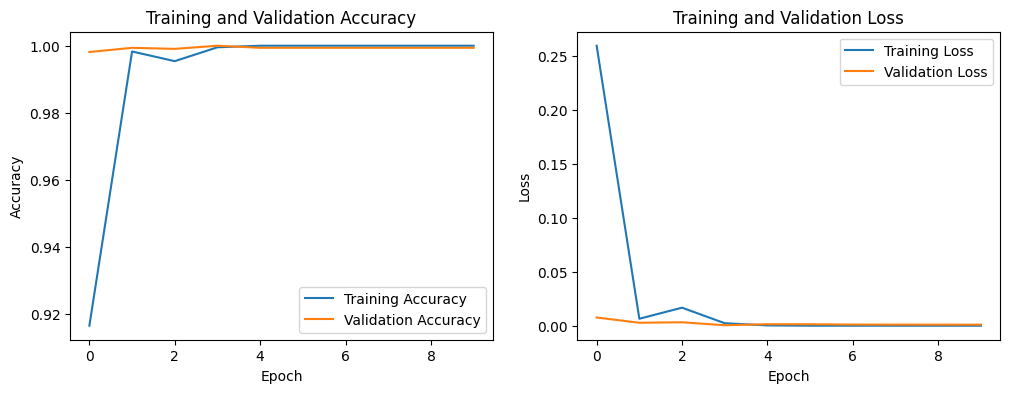

In [21]:
plot_training_history(history)

Real time gesture recognition

In [28]:
def recognize_gesture(model):
    cap = cv2.VideoCapture(0)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Flip the frame horizontally for a later selfie-view display
        frame = cv2.flip(frame, 1)

        # Convert the frame to RGB
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Process the frame and detect hands
        results = hands.process(rgb_frame)

        # Check if hands are detected
        if results.multi_hand_landmarks:
            # Create a blank image to draw landmarks
            landmark_image = np.zeros((64, 64, 1), dtype=np.float32)

            # Loop through the detected hands
            for hand_landmarks in results.multi_hand_landmarks:
                # Draw landmarks on the blank image
                for landmark in hand_landmarks.landmark:
                    x = int(landmark.x * 64)
                    y = int(landmark.y * 64)
                    cv2.circle(landmark_image, (x, y), 3, (1.0), -1)  # Use 1.0 for white color in normalized [0, 1]

            # Prepare the image for gesture recognition
            landmark_image = np.expand_dims(landmark_image, axis=0)  # Shape (1, 64, 64, 1)

            # Predict the gesture
            prediction = model.predict(landmark_image)
            command = np.argmax(prediction)

            # Map command to actions
            if command == 0:  # Left Click (Gesture "1")
                pyautogui.click()  # Simulate left mouse click
                print("Left Click")
            elif command == 6:  # Right Click (Gesture "2")
                pyautogui.click(button='right')  # Simulate right mouse click
                print("Right Click")
            elif command == 2:  # Scroll Up (Gesture "3")
                pyautogui.scroll(10)  # Scroll up
                print("Scroll Up")
            elif command == 9:  # Scroll Down (Gesture "4")
                pyautogui.scroll(-10)  # Scroll down
                print("Scroll Down")

        else:
            print("No hand detected; no action performed.")

        # Display the image with landmarks
        cv2.imshow('Hand Gesture Recognition', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


In [29]:
model = tf.keras.models.load_model('gesture_recognition_model.h5')
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(min_detection_confidence=0.5, min_tracking_confidence=0.5)
recognize_gesture(model)

No hand detected; no action performed.
No hand detected; no action performed.
No hand detected; no action performed.
No hand detected; no action performed.
No hand detected; no action performed.
No hand detected; no action performed.
No hand detected; no action performed.
No hand detected; no action performed.
No hand detected; no action performed.
No hand detected; no action performed.
No hand detected; no action performed.
No hand detected; no action performed.
No hand detected; no action performed.
No hand detected; no action performed.
No hand detected; no action performed.
No hand detected; no action performed.
No hand detected; no action performed.
No hand detected; no action performed.
No hand detected; no action performed.
No hand detected; no action performed.
No hand detected; no action performed.
No hand detected; no action performed.
No hand detected; no action performed.
No hand detected; no action performed.
No hand detected; no action performed.
No hand detected; no acti

KeyboardInterrupt: 